## Monte Carlo simulation for hedging AKER against FRO

#### Find the AR(1) model for EQNR and market negative correlated security FRO on the form 

$ Y_t = \beta_0 + \beta_1 t + \beta_2 Y_{t-1} + u_t $, where $ u_t$ ~ $N(0, \sigma_u^2) $



In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import json
from matplotlib import pyplot as plt

In [7]:
aker_data = yf.download('AKER.OL', start='2023-01-01', end='2024-12-01', interval='1d')
OSEBX_data = yf.download('OSEBX.OL', start='2023-01-01', end='2024-12-01', interval='1d')
fro_data = yf.download('FRO.OL', start='2023-01-01', end='2024-12-01', interval='1d')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [8]:
OSEBX_data.reset_index(inplace=True)
aker_data.reset_index(inplace=True)
fro_data.reset_index(inplace=True)


In [9]:
OSEBX_data['Norm'] = OSEBX_data['Close'] / OSEBX_data.loc[0, 'Close']
aker_data['Norm'] = aker_data['Close'] / aker_data.loc[0, 'Close']
fro_data['Norm'] = fro_data['Close'] / fro_data.loc[0, 'Close']

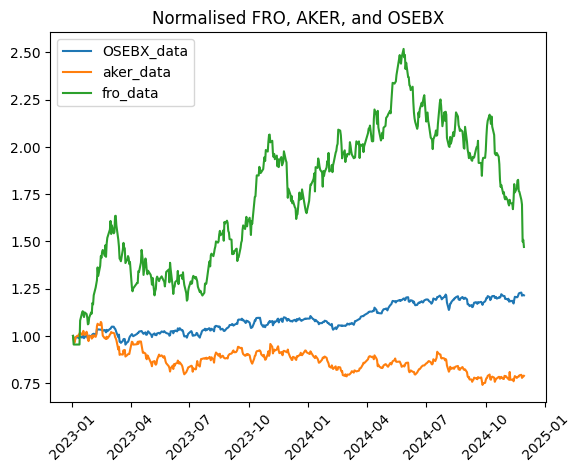

In [10]:
plt.plot(OSEBX_data['Date'], OSEBX_data['Norm'], label="OSEBX_data")
plt.plot(aker_data['Date'], aker_data['Norm'], label="aker_data")
plt.plot(fro_data['Date'], fro_data['Norm'], label="fro_data")

plt.title("Normalised FRO, AKER, and OSEBX")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [12]:
corr_mtx = pd.DataFrame({'AKER': aker_data['Close'], "FRO": fro_data['Close'], "OSEBX": OSEBX_data['Close']})
corr_mtx.corr()

,AKER,FRO,OSEBX
AKER,1.000000,-0.486260,-0.579825
FRO,-0.486260,1.000000,0.791188
OSEBX,-0.579825,0.791188,1.000000


In [14]:
corr_mtx.to_csv('AKER_Hedge.csv')

#### Simulate the random walk of AKER and FRO

Using the following R-code to estimate the linear function:

````R
data = read.csv('./AKER/AKER_Hedge.csv')

t = data$X + 1
n = length(t)

Y_t = data$AKER
Y_lag = c(NA, Y_t[1:(n-1)])

Y_hat_aker = lm(Y_t ~ t + Y_lag)
summary(Y_hat_aker)

Y_t = data$FRO
Y_lag = c(NA, Y_t[1:(n-1)])

Y_hat_fro = lm(Y_t ~ t + Y_lag)
summary(Y_hat_fro)
````

Which gives the following coeficents for AKER:

````R
Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 32.147549   9.604860   3.347 0.000881 ***
t           -0.011610   0.004747  -2.446 0.014811 *  
Y_lag        0.953379   0.013653  69.829  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 9.292 on 479 degrees of freedom
````

And for FRO:

````R
Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.2264710  1.4936685   1.491    0.137    
t           -0.0009225  0.0029577  -0.312    0.755    
Y_lag        0.9911782  0.0093177 106.375   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 5.357 on 479 degrees of freedom
````

No significant linear time-trend

Try this model instead:

$ Y_t^{FRO} = \beta_0 + \beta_1 y_{t-1} + u_t $

Gives the folowing result:

````R
Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.50219    1.20286    2.08    0.038 *  
Y_lag        0.98884    0.00552  179.15   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 5.352 on 480 degrees of freedom
````

So we have our two random walk models: 

$ Y_t^{AKER} = 32.147549 + -0.011610 t + 0.953379 Y_{t-1}^{AKER} + u_t^{AKER} $

$ Y_t^{FRO} = 2.50219 + 0.98884 Y_{t-1}^{FRO} + u_t^{FRO}$

In [189]:
with open('FRO_est.json') as file:
    coef_FRO = json.load(file)

with open('AKER_est.json') as file:
    coef_aker = json.load(file)

ser_aker = coef_aker['ser'][0]
ser_fro = coef_FRO['ser'][0]

coef_FRO = coef_FRO['coefficients']
coef_aker = coef_aker['coefficients']

n = len(corr_mtx)
y_aker = [0 for i in range(n)]
y_aker[0] = corr_mtx.loc[0, 'AKER']
y_fro = [0 for i in range(n)]
y_fro[0] = corr_mtx.loc[0, 'FRO']

for t in range(n-1):
    y_aker[t+1] = coef_aker[0]['Estimate'] + coef_aker[1]["Estimate"]*t + coef_aker[2]["Estimate"]*y_aker[t] + np.random.normal(0, ser_aker)

    u_t_fro = np.random.normal(0, ser_fro)
    # 50% chance of extra drift impact if already on increasin trend
    drift_impact = 0.5*coef_FRO[0]['Estimate'] if np.random.normal() >= 0.68 else 0 if u_t_fro >= 0 else 0
    y_fro[t+1] = coef_FRO[0]['Estimate'] + coef_FRO[1]["Estimate"] * y_fro[t] + u_t_fro + drift_impact


aker_data['Random Walk'] = y_aker
fro_data['Random Walk'] = y_fro

<function matplotlib.pyplot.show(close=None, block=None)>

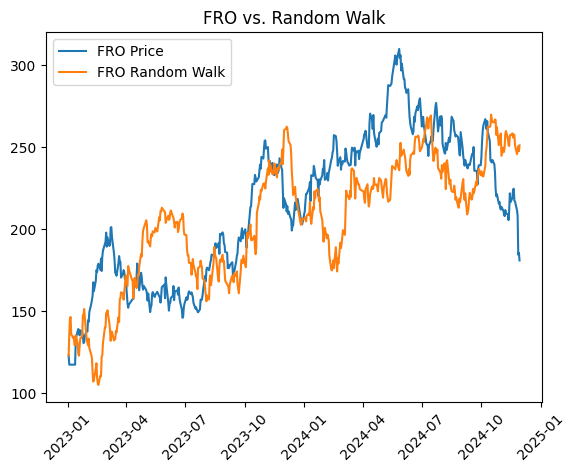

In [190]:
plt.plot(fro_data['Date'], fro_data['Close'], label="FRO Price")
plt.plot(fro_data['Date'], fro_data['Random Walk'], label="FRO Random Walk")

plt.xticks(rotation=45)
plt.legend()
plt.title("FRO vs. Random Walk")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

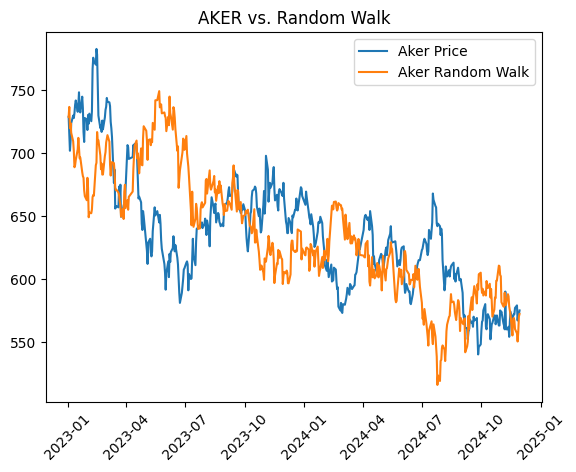

In [191]:
plt.plot(aker_data['Date'], aker_data['Close'], label="Aker Price")
plt.plot(aker_data['Date'], aker_data['Random Walk'], label="Aker Random Walk")

plt.xticks(rotation=45)
plt.legend()
plt.title("AKER vs. Random Walk")
plt.show

#### Monte Carlo simulation AKER vs. FRO to find optimal combination to hedge against risk over an investment over a month



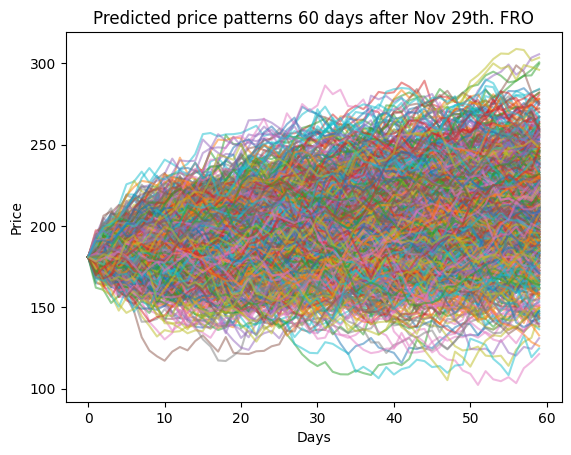

In [254]:
t = 60
days = [x for x in range(t)]
price_patterns_fro = []

runs = 1000
for i in range(1000):
    y_fro = [0 for _ in range(t)]
    y_fro[0] = float(corr_mtx.loc[n-1, 'FRO'])

    for j in range(t-1):  
        u_t_fro = np.random.normal(0, ser_fro)

        # 25% chance of extra drift impact if already on an increasing trend
        drift_impact = (
            0.5 * coef_FRO[0]['Estimate'] if np.random.normal() >= 0.68 and u_t_fro >= 0 else 0
        )

        y_fro[j+1] = coef_FRO[0]['Estimate'] + coef_FRO[1]["Estimate"] * y_fro[j] + u_t_fro + drift_impact

    price_patterns_fro.append(list(y_fro))


for patt in price_patterns_fro:
    plt.plot(days, patt, alpha=0.5)

plt.title(f'Predicted price patterns {t} days after Nov 29th. FRO')
plt.xlabel('Days')
plt.ylabel('Price')
plt.show()


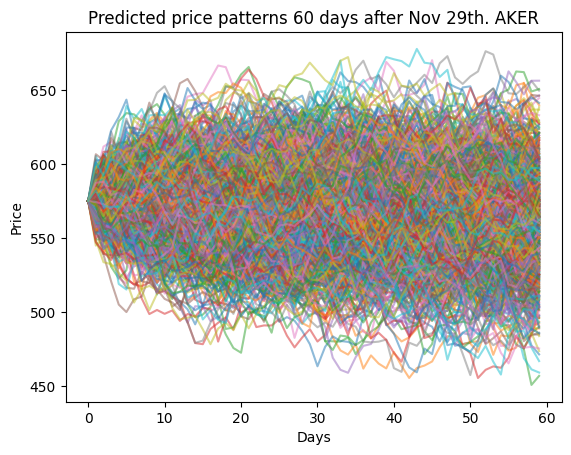

In [255]:
days = [x for x in range(t)]
price_patterns_aker = []

runs = 1000
for i in range(runs):
    y_aker = [0 for _ in range(t)]
    y_aker[0] = float(corr_mtx.loc[n-1, 'AKER'])

    for j in range(t-1):  
        u_t_aker = np.random.normal(0, ser_aker)

        y_aker[j+1] = coef_aker[0]['Estimate'] + coef_aker[1]["Estimate"]*(n+j) + coef_aker[2]["Estimate"] * y_aker[j] + u_t_aker

    price_patterns_aker.append(list(y_aker))


for patt in price_patterns_aker:
    plt.plot(days, patt, alpha=0.5)

plt.title(f'Predicted price patterns {t} days after Nov 29th. AKER')
plt.xlabel('Days')
plt.ylabel('Price')
plt.show()


In [256]:
fro_patts = np.array(price_patterns_fro)
aker_patts = np.array(price_patterns_aker)

In [257]:
ratios = {"AKER": 0, "FRO": 0}

for i in range(len(fro_patts)):
    if np.var(fro_patts[i]) < np.var(aker_patts[i]):
        ratios['FRO'] += 1
    else: ratios["AKER"] += 1

r = ratios["AKER"] / runs
print(f"Buy AKER / FRO at ratio {round(r*100, 1)}/{round(100*(1-r), 1)}")

Buy AKER / FRO at ratio 29.4/70.6


### Simulated portfolio using hedge ratio

Text(0.5, 1.0, 'Portfolio Return given hedged position AKER/FRO')

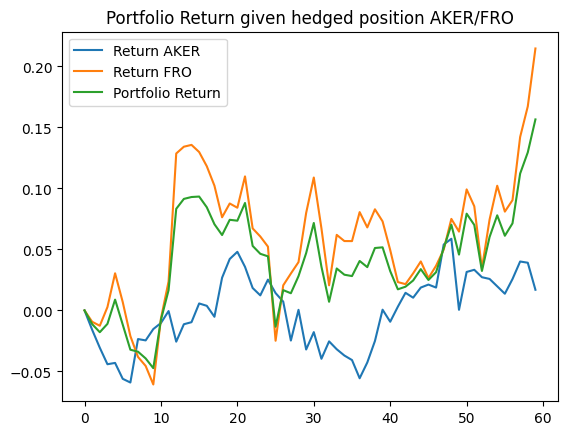

In [258]:
portfolio_value = 1000
y_aker = [0 for _ in range(t)]
y_aker[0] = float(corr_mtx.loc[n-1, 'AKER'])

for j in range(t-1):  
    u_t_aker = np.random.normal(0, ser_aker)

    y_aker[j+1] = coef_aker[0]['Estimate'] + coef_aker[1]["Estimate"]*(n+j) + coef_aker[2]["Estimate"] * y_aker[j] + u_t_aker

y_fro = [0 for _ in range(t)]
y_fro[0] = float(corr_mtx.loc[n-1, 'FRO'])

for j in range(t-1):  
    u_t_fro = np.random.normal(0, ser_fro)

    # 25% chance of extra drift impact if already on an increasing trend
    drift_impact = (
        0.5 * coef_FRO[0]['Estimate'] if np.random.normal() >= 0.68 and u_t_fro >= 0 else 0
    )

    y_fro[j+1] = coef_FRO[0]['Estimate'] + coef_FRO[1]["Estimate"] * y_fro[j] + u_t_fro + drift_impact

avkast_fro = np.array(y_fro) / y_fro[0] - 1
avkast_aker = np.array(y_aker) / y_aker[0] - 1

portfolio_avkast = avkast_aker*r + avkast_fro*(1-r)

plt.plot(days, avkast_aker, label="Return AKER")
plt.plot(days, avkast_fro, label="Return FRO")
plt.plot(days, portfolio_avkast, label="Portfolio Return")
plt.legend()
plt.title("Portfolio Return given hedged position AKER/FRO")


### Check against theoretical optimum:

Let $ \sigma_{portfolio}^2 = Var(r*AKER + (1-r)FRO) = r^2 \sigma_{AKER}^2 + (1-r)^2 \sigma_{FRO}^2 + 2 r (1-r) Cov(AKER,FRO) = r^2 \sigma_{AKER}^2 + (1-r)^2 \sigma_{FRO}^2 + 2 r (1-r) \sigma_{AKER} \sigma_{FRO} \rho $

We have 

$ \rho = Corr(AKER,FRO) = -0.486260 $

$ \sigma_{AKER} = SER_{AKER} = 9.292 $

$ \sigma_{FRO} = SER_{FRO} = 5.3521 $

Giving us $\frac{d \sigma_{portfolio}^2 }{dr} = 0 \Leftrightarrow r \approx 0.32$